In [1]:
from common import *
from process_ntuples import *
from process_df import *
from plotting import *
from cuts import apply_cuts, apply_pt_cut
import matplotlib.pyplot as plt
import pickle
import time

import tensorflow as tf
from tensorflow.keras import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras import layers

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve

from tensorflow.keras.callbacks import EarlyStopping

#weights and biases imports
import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint, WandbCallback

Welcome to JupyROOT 6.28/00


2023-06-19 11:28:26.670814: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-19 11:28:28.917666: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


$D^{+}$ : 411

$\Lambda_C^{+}$ : 4122

Apply Cuts Fiducial Region cuts ($𝐷^{+}$ $𝑝_T$ > 8 GeV, |𝜂| < 2.2). ***See cuts.py on how the cuts are applied***

In [2]:
print(tf.config.list_physical_devices('GPU'))
# Check if tensorflow is using GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


In [3]:
dir_path = "/global/cfs/cdirs/atlas/gottino/Charm/Analysis/run_batch_gup/ntuples"

files = os.listdir(dir_path)

DMesonsTTree = process_ntuple(dir_path, files[0])
LambdaMesonsTTree = process_ntuple(dir_path, files[1])

branches = ["DMesons_pt", "DMesons_eta", "DMesons_m", "DMesons_fitOutput__Lxy", "DMesons_costhetastar", "DMesons_pdgId", 
            "DMesons_daughterInfo__pt", "DMesons_daughterInfo__eta", "DMesons_daughterInfo__phi", "DMesons_daughterInfo__pdgId",
           "DMesons_fitOutput__ImpactSignificance"]

print(files)

['CharmAnalysis.mc.ForcedDecay.Dplus.tree.root', 'CharmAnalysis.mc.ForcedDecay.LabmdaC.tree.root']


In [4]:
# DMesons_df = generate_df(DMesonsTTree, branches, 4000000)
# DMesons_df = apply_cuts(DMesons_df)

# pd.set_option('display.max_rows', 10)
# DMesons_df

In [5]:
# Lambda_df = generate_df(LambdaMesonsTTree, branches, 4000000)
# Lambda_df = apply_cuts(Lambda_df)

# pd.set_option('display.max_rows', 10)
# Lambda_df

In [102]:
# save(DMesons_df, "DMesons_df")
# save(Lambda_df, "Lambda_df")

In [103]:
DMesons_df = remove_duplicates(DMesons_df)
Lambda_df = remove_duplicates(Lambda_df)

Removed 0 duplicate particles
Removed 0 duplicate particles


In [11]:
DMesons_df = load("DMesons_df")
Lambda_df = load("Lambda_df")

In [12]:
DMesons_df = DMesons_df.head(1000000)
Lambda_df = Lambda_df.head(1000000)

In [13]:
#separates each particle of the event into it's own event in a new data frame (for training)
def separate(df):
    dfs = []
    for index, row in df.iterrows():

        #reco Ds
        pts = row['DMesons_pt']
        etas = row['DMesons_eta']
        ms = row['DMesons_m']
        lxys = row['DMesons_fitOutput__Lxy']
        costhetastars = row['DMesons_costhetastar']
        impacts = row['DMesons_fitOutput__ImpactSignificance']
        pdgids = row["DMesons_pdgId"]

        #reco Ds Daughter info
        daughter_pts = row["DMesons_daughterInfo__pt"]
        daughter_etas = row["DMesons_daughterInfo__eta"]
        daughter_phis = row["DMesons_daughterInfo__phi"]
        daughter_pdgIds = row["DMesons_daughterInfo__pdgId"]

        d = {df.columns[0]: pts, df.columns[1]: etas, df.columns[2]: ms, df.columns[3]: lxys, 
             df.columns[4]: costhetastars, df.columns[5]: pdgids, 

             df.columns[6]: daughter_pts, df.columns[7]: daughter_etas, df.columns[8]: daughter_phis, 
             df.columns[9]: daughter_pdgIds, 
             
             df.columns[10]: impacts}
        
        df = pd.DataFrame(data=d)

        dfs.append(df)

    df = pd.concat(dfs)
    df = df.reset_index(drop = True)
    return df

In [14]:
DMesons_df = separate(DMesons_df)
Lambda_df = separate(Lambda_df)

In [15]:
DMesons_df

,DMesons_pt,DMesons_eta,DMesons_m,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_pdgId,DMesons_daughterInfo__pt,DMesons_daughterInfo__eta,DMesons_daughterInfo__phi,DMesons_daughterInfo__pdgId,DMesons_fitOutput__ImpactSignificance
0,10.047125,0.081824,1862.417603,2.339530,0.254870,411,"[6.094892978668213, 1.3074619770050049, 2.7334...","(0.15998553, 0.011107716, -0.0614343)","(2.6128821, 2.7195172, 2.9228168)","(-321, 211, 211)",0.554385
1,18.993742,-1.661963,1853.906250,1.918414,-0.367302,411,"[6.457057952880859, 5.970093250274658, 6.63757...","(-1.608788, -1.6307458, -1.7315177)","(-0.371787, -0.5164238, -0.4971406)","(-321, 211, 211)",1.809502
2,18.993742,-1.661963,2398.886963,1.918414,-0.065073,4122,"[6.605627059936523, 6.457057952880859, 5.96782...","(-1.7326077, -1.608788, -1.6305238)","(-0.49662885, -0.371787, -0.5161313)","(2212, -321, 211)",1.809502
3,10.118494,0.041659,1874.203125,2.890126,0.068331,411,"[3.7944977283477783, 3.3083105087280273, 3.065...","(-0.073717244, 0.22605924, -0.017923404)","(0.753864, 0.6827104, 0.920779)","(-321, 211, 211)",2.292919
4,10.118494,0.041659,2468.180664,2.890126,0.427697,4122,"[3.3083105087280273, 3.7944977283477783, 3.065...","(0.22605924, -0.073717244, -0.017923404)","(0.6827104, 0.753864, 0.920779)","(2212, -321, 211)",2.292919
...,...,...,...,...,...,...,...,...,...,...,...
1660074,12.158312,0.132812,1869.685547,0.588506,0.557646,411,"[3.9736881256103516, 6.078239440917969, 2.1163...","(0.11824833, 0.23036675, -0.12431251)","(0.63422835, 0.6597335, 0.72828233)","(-321, 211, 211)",1.875327
1660075,12.158312,0.132812,2280.860107,0.588506,0.823664,4122,"[6.078239440917969, 3.9736881256103516, 2.1163...","(0.23036675, 0.11824833, -0.12431251)","(0.6597335, 0.63422835, 0.72828233)","(2212, -321, 211)",1.875327
1660076,8.233737,0.773861,1875.938477,1.890014,0.976978,411,"[4.407941818237305, 1.67171311378479, 2.177361...","(0.76943475, 0.43246573, 0.99564147)","(-1.4902973, -1.4156551, -1.617877)","(-321, 211, 211)",1.229689
1660077,39.016086,1.315515,1884.218384,2.228456,0.830586,411,"[14.05517578125, 4.844608783721924, 20.0946331...","(1.31107, 1.3813725, 1.3015553)","(-2.3042684, -2.2286644, -2.3332112)","(-321, 211, 211)",0.373849


In [16]:
Lambda_df

,DMesons_pt,DMesons_eta,DMesons_m,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_pdgId,DMesons_daughterInfo__pt,DMesons_daughterInfo__eta,DMesons_daughterInfo__phi,DMesons_daughterInfo__pdgId,DMesons_fitOutput__ImpactSignificance
0,15.837362,-1.985341,2277.830078,0.042679,-0.245128,4122,"[6.491756916046143, 3.2679483890533447, 6.1132...","(-2.0230656, -2.0707278, -1.8890115)","(-2.1058285, -2.2039685, -2.201573)","(2212, -321, 211)",2.583055
1,15.837362,-1.985341,2369.549072,0.042679,-0.176329,4122,"[6.095479488372803, 3.2679483890533447, 6.5212...","(-1.8896221, -2.0707278, -2.0236218)","(-2.2013154, -2.2039685, -2.106475)","(2212, -321, 211)",2.583055
2,98.787680,-0.293096,1919.408691,2.126933,0.062004,411,"[29.078584671020508, 10.136245727539062, 59.80...","(-0.28745878, -0.29004973, -0.29698882)","(-2.6987991, -2.6463094, -2.698718)","(-321, 211, 211)",1.114047
3,98.787680,-0.293096,2260.435791,2.126933,0.384769,4122,"[59.58535385131836, 29.078584671020508, 10.138...","(-0.29630095, -0.28745878, -0.28985468)","(-2.6987205, -2.6987991, -2.646201)","(2212, -321, 211)",1.114047
4,8.605864,0.075369,2293.048584,0.099623,0.443427,4122,"[2.7384893894195557, 4.709741592407227, 1.2400...","(0.19276412, 0.01101852, 0.053698417)","(-2.1192122, -1.8384731, -2.1108038)","(2212, -321, 211)",4.643901
...,...,...,...,...,...,...,...,...,...,...,...
1480995,12.711447,0.398302,2314.117432,0.308488,-0.861106,4122,"[9.886434555053711, 1.8161219358444214, 1.0250...","(0.36236963, 0.36378425, 0.7629232)","(-1.0364554, -0.9701696, -1.1643318)","(2212, -321, 211)",2.327402
1480996,21.216146,-1.984951,2248.399170,0.279758,0.001884,4122,"[8.379639625549316, 5.4667768478393555, 7.4333...","(-2.0064626, -1.9753618, -1.9613183)","(2.7535362, 2.623876, 2.6317556)","(2212, -321, 211)",0.396443
1480997,21.216146,-1.984951,2332.425537,0.279758,0.072258,4122,"[7.409440040588379, 5.4667768478393555, 8.3824...","(-1.9619988, -1.9753618, -2.0066454)","(2.63208, 2.623876, 2.7535088)","(2212, -321, 211)",0.396443
1480998,17.151113,1.399941,2304.857910,0.190047,-0.483062,4122,"[7.187153339385986, 3.9298830032348633, 6.0532...","(1.3936229, 1.3551356, 1.4283212)","(2.422828, 2.6021826, 2.4083762)","(2212, -321, 211)",2.272321


In [18]:
save(DMesons_df, "DMesons_df_separated")
save(Lambda_df, "Lambda_df_separated")

# DMesons_df = load("DMesons_df_separated")
# Lambda_df = load("Lambda_df_separated")

In [24]:
#takes tuples of shape (2,) / (index, column)
def remove_particles_from_df(df, tuple_list):
    for tup in tuple_list:
        index, column = tup
        print(index, column)
        
        new_df = df.copy()
        for i in range(len(DMesons_df.iloc[index, 0][column]) + 1):
            #new_df["DMesons_daughterInfo__pt"] = new_df["DMesons_daughterInfo__pt"].apply(lambda x: print(x))
            val = new_df.iloc[index, i][column]
            print(val)
    df = df.drop(index, axis = 0)
    return df
#df = remove_particles_from_df(DMesons_df, remove_lambda)

pd.set_option('display.max_rows', 10)

In [19]:
def count(df):
    D = 0
    Lambda = 0
    for pdgId in df["DMesons_pdgId"]:
        if pdgId == 411 or pdgId == 0:
            D+=1
        elif pdgId == 4122 or pdgId == 1:
            Lambda+=1
    return D, Lambda

count(DMesons_df)

(846608, 811534)

In [20]:
def func(x):
    if x == 411:
        return 'only_411'
    elif x == 4122:
        return 'only_4122'
    # else:
    #     return "both"

DMesons_df['particle_type'] = DMesons_df['DMesons_pdgId'].apply(func)

# separate the rows based on the new column
only_411 = DMesons_df[DMesons_df['particle_type'] == 'only_411']
only_4122 = DMesons_df[DMesons_df['particle_type'] == 'only_4122']
#both = DMesons_df[DMesons_df['particle_type'] == 'both']

#new_df = DMesons_df[DMesons_df['particle_type'] != 'both']
# new_df = new_df.reset_index(drop=True)

# new_df = new_df.drop('particle_type', axis=1)

In [21]:
save(only_4122, "Sherpa_DMesons_only_4122")

In [22]:
# create a new column 'particle_type' based on the pdgId column

def func(x):
    if x == 411:
        return 'only_411'
    elif x == 4122:
        return 'only_4122'
    # else:
    #     return "both"

Lambda_df['particle_type'] = Lambda_df['DMesons_pdgId'].apply(func)

# separate the rows based on the new column
only_411 = Lambda_df[Lambda_df['particle_type'] == 'only_411']
only_4122 = Lambda_df[Lambda_df['particle_type'] == 'only_4122']
#both = DMesons_df[DMesons_df['particle_type'] == 'both']

# new_df = Lambda_df[Lambda_df['particle_type'] != 'both']
# new_df = new_df.reset_index(drop=True)

# new_df = new_df.drop('particle_type', axis=1)

In [23]:
save(only_4122, "Lambda_only_4122")

In [29]:
# Read
Lambda_only_4122 = load("Lambda_only_4122")
DMesons_only_4122 = load("Sherpa_DMesons_only_4122")

In [30]:
len(DMesons_only_4122)

690863

In [31]:
DMesons_only_4122['DMesons_pdgId'] = DMesons_only_4122['DMesons_pdgId'].replace({4122: 411})
Lambda_only_4122 = Lambda_only_4122.reset_index(drop=True)
DMesons_only_4122 = DMesons_only_4122.reset_index(drop=True)
DMesons_only_4122

,DMesons_pt,DMesons_eta,DMesons_m,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_pdgId,DMesons_daughterInfo__pt,DMesons_daughterInfo__eta,DMesons_daughterInfo__phi,DMesons_daughterInfo__pdgId,DMesons_fitOutput__ImpactSignificance,particle_type
0,124.551781,0.616144,2252.343994,1.000073,0.309355,411,"[45.35352325439453, 55.5874137878418, 23.73572...","(0.62828386, 0.6060324, 0.61673385)","(3.135228, 3.1389863, -3.1324918)","(2212, -321, 211)",1.687575,only_4122
1,52.491680,0.628072,2420.752197,9.001939,-0.999371,411,"[45.325809478759766, 3.1020970344543457, 3.886...","(0.6306876, 0.61715966, 0.6021761)","(3.1351142, 3.1380522, -3.100118)","(2212, -321, 211)",4.709635,only_4122
2,51.824703,0.628606,2289.998535,0.752138,-0.955626,411,"[45.20779800415039, 5.494213104248047, 1.12326...","(0.6285973, 0.60806257, 0.7257996)","(3.135263, 3.1376371, 3.0532124)","(2212, -321, 211)",0.082626,only_4122
3,74.569516,0.623304,2320.748779,0.825154,-0.988731,411,"[45.4151725769043, 5.492096424102783, 23.73572...","(0.6285476, 0.6079869, 0.61673385)","(3.1352143, 3.1375391, -3.1324918)","(2212, -321, 211)",0.285478,only_4122
4,52.139363,0.628442,2114.455566,14.295114,-0.967880,411,"[45.4952392578125, 5.527915000915527, 1.113548...","(0.6305013, 0.60626864, 0.66872984)","(3.1350088, 3.1403995, -3.1118574)","(2212, -321, 211)",4.459208,only_4122
...,...,...,...,...,...,...,...,...,...,...,...,...
690858,15.015752,-1.621316,2128.959717,1.055468,-0.955383,411,"[10.978409767150879, 1.5513936281204224, 2.492...","(-1.6365633, -1.4952528, -1.6247052)","(-0.16868365, -0.11923864, -0.22785482)","(-2212, 321, -211)",4.102871,only_4122
690859,13.776949,-1.625336,2419.603516,0.624960,-0.933207,411,"[11.055854797363281, 1.5394558906555176, 1.245...","(-1.6374356, -1.5005118, -1.6150558)","(-0.1682525, -0.11801015, 0.16930138)","(-2212, 321, -211)",1.601410,only_4122
690860,16.353774,-1.603238,2288.062256,3.461010,-0.961579,411,"[11.229562759399414, 1.516668438911438, 3.6428...","(-1.6382093, -1.4983779, -1.5304362)","(-0.16720171, -0.11406519, -0.21755505)","(-2212, 321, -211)",2.295237,only_4122
690861,14.328731,-1.612592,2169.589355,1.799214,-0.948991,411,"[11.196073532104492, 1.5245026350021362, 1.622...","(-1.6378483, -1.4999491, -1.5262128)","(-0.16747509, -0.1153605, -0.27906275)","(-2212, 321, -211)",2.297870,only_4122


In [35]:
Lambda_only_4122 = Lambda_only_4122.head(500000)
DMesons_only_4122 = DMesons_only_4122.head(500000)

combined_df = pd.concat([Lambda_only_4122, DMesons_only_4122], axis=0)

# Shuffle the rows of the combined data frame
shuffled_df = combined_df.sample(frac=1).reset_index(drop=True)

Text(0.5, 0, 'Mass (MeV)')

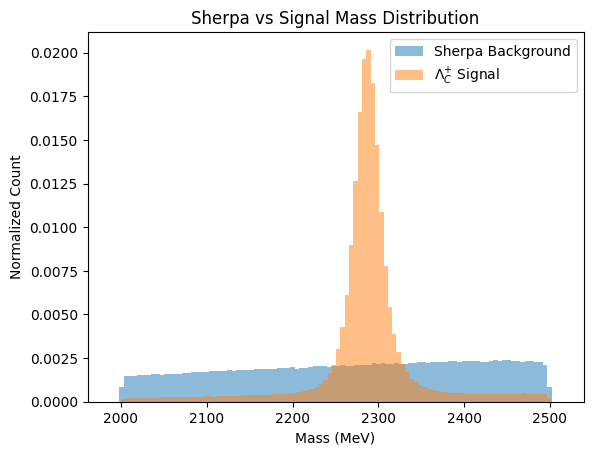

In [34]:
counts, bins, _ = plt.hist(DMesons_only_4122["DMesons_m"], bins=100)
counts2, bins2, _ = plt.hist(Lambda_only_4122["DMesons_m"], bins=100)
# Normalize the histogram using the formula
density = counts / (sum(counts) * np.diff(bins))
density2 = counts2 / (sum(counts2) * np.diff(bins2))

# Plot the normalized histogram
plt.clf()
plt.bar(bins[:-1], density, width=np.diff(bins), align='edge', alpha=0.5, label = "Sherpa Background")
plt.bar(bins2[:-1], density2, width=np.diff(bins2), align='edge', alpha=0.5, label = "$\Lambda_C^{+}$ Signal")
plt.title("Sherpa vs Signal Mass Distribution")
plt.legend()
plt.ylabel("Normalized Count")
plt.xlabel("Mass (MeV)")

In [36]:
shuffled_df['DMesons_daughterInfo__pdgId'] = [(2212, -321, 211)] * len(shuffled_df)

In [63]:
#DMesons_only_4122['DMesons_daughterInfo__pdgId'] = [(2212, -321, 211)] * len(DMesons_only_4122)

/tmp/ipykernel_42831/3865868314.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DMesons_only_4122['DMesons_daughterInfo__pdgId'] = [(2212, -321, 211)] * len(DMesons_only_4122)


In [37]:
shuffled_df["DMesons_daughterInfo__eta"] = shuffled_df["DMesons_daughterInfo__eta"].apply(list)
shuffled_df["DMesons_daughterInfo__phi"] = shuffled_df["DMesons_daughterInfo__phi"].apply(list)

In [38]:
#for singal vs background comparison
# DMesons_only_4122["DMesons_daughterInfo__eta"] = DMesons_only_4122["DMesons_daughterInfo__eta"].apply(list)
# DMesons_only_4122["DMesons_daughterInfo__phi"] = DMesons_only_4122["DMesons_daughterInfo__phi"].apply(list)

# Lambda_only_4122["DMesons_daughterInfo__eta"] = Lambda_only_4122["DMesons_daughterInfo__eta"].apply(list)
# Lambda_only_4122["DMesons_daughterInfo__phi"] = Lambda_only_4122["DMesons_daughterInfo__phi"].apply(list)

In [ ]:
#shuffled_df_daughter = shuffled_df[["DMesons_daughterInfo__pt", "DMesons_daughterInfo__eta", "DMesons_daughterInfo__phi", "DMesons_daughterInfo__pdgId", "particle_type"]]

In [39]:
#separate the daughter info
daughter_pts = []
daughter_etas = []
daughter_phis = []

for index, row in shuffled_df.iterrows():

    pts = row['DMesons_daughterInfo__pt']
    etas = row['DMesons_daughterInfo__eta']
    phis = row['DMesons_daughterInfo__phi']
    
    for pt, eta, phi in zip(pts, etas, phis):
        daughter_pts.append(pt)
        daughter_etas.append(eta)
        daughter_phis.append(phi)

In [40]:
#particle1 is proton, or pion in D+ hyp
#particle2 is kaon
#particle3 is pion

particle1_pt = []
particle2_pt = []
particle3_pt = []

particle1_eta = []
particle2_eta = []
particle3_eta = []

particle1_phi = []
particle2_phi = []
particle3_phi = []

for i in range(0, len(daughter_pts), 3):
    #daughter_pt
    particle1_pt.append(daughter_pts[i])
    particle2_pt.append(daughter_pts[i+1])
    particle3_pt.append(daughter_pts[i+2])
    
    #daughter_eta
    particle1_eta.append(daughter_etas[i])
    particle2_eta.append(daughter_etas[i+1])
    particle3_eta.append(daughter_etas[i+2])
    
    #daughter_phi
    particle1_phi.append(daughter_phis[i])
    particle2_phi.append(daughter_phis[i+1])
    particle3_phi.append(daughter_phis[i+2])

In [ ]:
#D+ hypothesis
#inv_mass1 is pk assuming proton is pion for all candidates
#inv_mass2 is kpi
#inv_mass3 pipi (assuming p is pi)

#pions
#inv_mass4 is pion pion (first pion was proton) (second pion was kaon)
#inv_mass5 is pion pion (first pion was kaon) (second is still pion)
#inv_mass6 is pion pion (first pion was proton) (second is still pion)

#Lambda Hypothesis
#inv_mass7 is pk assuming proton is proton
#inv_mass8 is kpi
#inv_mass9 ppi

In [59]:
k_mass = 0.493677 #Gev/c^2
pi_mass = 0.13957 #Gev/c^2
p_mass = 0.938 #Gev/c^2

def createTLorentzVectors(df):
    TLorentzVectorList = []
    
    for index, row in df.iterrows():
        pts = row['DMesons_daughterInfo__pt']
        etas = row['DMesons_daughterInfo__eta']
        phis = row['DMesons_daughterInfo__phi']
        pdgids = row['DMesons_daughterInfo__pdgId']
        types = row["particle_type"]
        
        def assign_mass():
            if types == "only_411" or "only_4122":
                #D+ Hypothesis: assume proton is pion for 
                #Lambda Hypothesis: keep proton as proton
                return pi_mass
            else:
                raise Exception("Are there more particle types?")
            
        for pt, eta, phi, pdgid in zip(pts, etas, phis, pdgids):
            if pdgid == 211:
                m = pi_mass
            elif pdgid == -321:
                m = pi_mass
            elif pdgid == 2212:
                m = assign_mass()
            else:
                continue

            p = ROOT.TLorentzVector()
            p.SetPtEtaPhiM(pt, eta, phi, m)
            TLorentzVectorList.append(p)

    return TLorentzVectorList

inv_mass_squared = lambda p1, p2: (p1 + p2).M2()

In [60]:
LorentzVectors = createTLorentzVectors(shuffled_df)
reshaped_list = [LorentzVectors[i:i+3] for i in range(0, len(LorentzVectors), 3)]
np.shape(reshaped_list)

(1000000, 3)

In [42]:
# LorentzVectors1 = createTLorentzVectors(Lambda_only_4122)
# reshaped_list1 = [LorentzVectors1[i:i+3] for i in range(0, len(LorentzVectors1), 3)]
# np.shape(reshaped_list1)

In [43]:
# LorentzVectors2 = createTLorentzVectors(DMesons_only_4122)
# reshaped_list2 = [LorentzVectors2[i:i+3] for i in range(0, len(LorentzVectors2), 3)]
# np.shape(reshaped_list2)

In [62]:
pk_list = []
kpi_list = []
ppi_list = []

#find the ordering of the Lorentz Vectors

#Lambda Hypothesis
# p_LorentzVectors = []
# k_LorentzVectors = []
# pi_LorentzVectors = []
# for i in LorentzVectors:
#     if round(i.M(), 3) == p_mass:
#         p_LorentzVectors.append(i)
#     elif round(i.M(), 6) == k_mass:
#         k_LorentzVectors.append(i)
#     elif round(i.M(), 4) == 0.1396:
#         pi_LorentzVectors.append(i)

#D+ Hypothesis
# p_LorentzVectors = []
# k_LorentzVectors = []
# pi_LorentzVectors = []
# for sublist in reshaped_list:
#     for i in range(len(sublist)):
#         if round(sublist[i].M(), 4) == 0.1396 and i == 0:
#             p_LorentzVectors.append(sublist[0])
#         elif round(sublist[i].M(), 4) == 0.4937 and i == 1:
#             k_LorentzVectors.append(sublist[1])
#         elif round(sublist[i].M(), 4) == 0.1396 and i == 2:
#             pi_LorentzVectors.append(sublist[2])

#Pions
p_LorentzVectors = []
k_LorentzVectors = []
pi_LorentzVectors = []
for sublist in reshaped_list:
    for i in range(len(sublist)):
        if round(sublist[i].M(), 4) == 0.1396 and i == 0:
            p_LorentzVectors.append(sublist[0])
        elif round(sublist[i].M(), 4) == 0.1396 and i == 1:
            k_LorentzVectors.append(sublist[1])
        elif round(sublist[i].M(), 4) == 0.1396 and i == 2:
            pi_LorentzVectors.append(sublist[2])

In [63]:
for i in range(len(p_LorentzVectors)):
    pk = inv_mass_squared(p_LorentzVectors[i], k_LorentzVectors[i])
    kpi = inv_mass_squared(k_LorentzVectors[i], pi_LorentzVectors[i])
    ppi = inv_mass_squared(p_LorentzVectors[i], pi_LorentzVectors[i])
    pk_list.append(pk)
    kpi_list.append(kpi)
    ppi_list.append(ppi)

In [197]:
#Lambda
# for i in range(len(p_LorentzVectors)):
#     ppi = inv_mass_squared(p_LorentzVectors[i], pi_LorentzVectors[i])
#     ppi_list.append(ppi)

In [190]:
#D
# for i in range(len(p_LorentzVectors)):
#     pipi = inv_mass_squared(p_LorentzVectors[i], pi_LorentzVectors[i])
#     pipi_list.append(pipi)

In [64]:
#D+ hypothesis
#inv_mass1 is pk assuming proton is pion for all candidates
#inv_mass2 is kpi
#inv_mass3 pipi (assuming p is pi)

#pions
#inv_mass4 is pion pion (first pion was proton) (second pion was kaon)
#inv_mass5 is pion pion (first pion was kaon) (second is still pion)
#inv_mass6 is pion pion (first pion was proton) (second is still pion)

#Lambda Hypothesis
#inv_mass7 is pk assuming proton is proton
#inv_mass8 is kpi
#inv_mass9 ppi

shuffled_df['inv_mass7'] = pk_list
shuffled_df['inv_mass8'] = kpi_list
shuffled_df['inv_mass9'] = ppi_list

In [65]:
shuffled_df

,DMesons_pt,DMesons_eta,DMesons_m,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_pdgId,DMesons_daughterInfo__pt,DMesons_daughterInfo__eta,DMesons_daughterInfo__phi,DMesons_daughterInfo__pdgId,...,particle_type,inv_mass1,inv_mass2,inv_mass3,inv_mass4,inv_mass5,inv_mass6,inv_mass7,inv_mass8,inv_mass9
0,13.339022,1.860289,2234.231201,0.745180,-0.983574,4122,"[9.580430030822754, 1.9775121212005615, 1.8520...","[1.8644881, 1.844697, 1.817142]","[2.6661806, 2.629243, 2.3631094]","(2212, -321, 211)",...,only_4122,1.501837,0.767280,1.805035,2.536952,0.767280,2.824406,0.172331,0.338731,1.805035
1,14.615392,-1.324401,2049.302002,0.003493,-0.184568,411,"[9.498269081115723, 4.112053394317627, 1.02307...","[-1.2647753, -1.4247515, -1.4244021]","[-2.1002924, -1.9965936, -2.0250294]","(2212, -321, 211)",...,only_4122,2.183498,0.405532,0.501719,3.472467,0.405532,1.468733,1.509121,0.125460,0.501719
2,10.214175,-1.998536,2269.313721,0.534834,-0.015658,4122,"[5.685783863067627, 3.024578809738159, 1.58216...","[-2.0040536, -2.0660822, -1.7743276]","[-0.16750209, -0.33900744, 0.0556978]","(2212, -321, 211)",...,only_4122,1.276313,1.554977,1.053611,2.622791,1.554977,2.106215,0.655236,1.242029,1.053611
3,8.499864,1.565644,2296.626953,0.276483,0.156741,411,"[5.452791213989258, 2.505634069442749, 0.64398...","[1.5292919, 1.4826292, 1.9550756]","[0.09720072, 0.17226325, -0.45709223]","(2212, -321, 211)",...,only_4122,0.930798,1.394549,1.850725,2.171020,1.394549,2.862713,0.198459,1.080657,1.850725
4,10.147655,-1.107224,2349.665283,0.005217,-0.952701,411,"[5.081589698791504, 0.8591739535331726, 4.2491...","[-1.1354359, -1.0699766, -1.0733323]","[2.7746234, 2.975156, 2.6695848]","(2212, -321, 211)",...,only_4122,1.934794,1.778746,0.400257,2.941094,1.778746,1.943212,0.356915,0.477541,0.400257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,8.119562,0.835657,2336.029541,0.036728,-0.920548,411,"[5.349454402923584, 0.8483601808547974, 1.8340...","[0.85046715, 0.49429214, 0.9168487]","[-0.7029902, -0.52890426, -0.8127337]","(2212, -321, 211)",...,only_4122,2.764151,1.316856,0.261432,3.748849,1.316856,1.430132,0.910878,0.506526,0.261432
999996,9.043790,-2.256318,2130.628418,1.803615,0.843925,411,"[3.302771806716919, 5.071074962615967, 0.72106...","[-2.2190878, -2.3123138, -1.9250401]","[0.5948031, 0.61068374, 0.29398194]","(2212, -321, 211)",...,only_4122,0.590739,1.405397,0.581983,2.897189,1.405397,1.583720,0.233199,1.159236,0.581983
999997,18.372461,1.980019,2289.572998,0.582422,-0.721910,4122,"[12.833571434020996, 3.033148765563965, 2.5402...","[1.9859539, 1.8834342, 2.043011]","[1.7542429, 1.8222208, 1.9490958]","(2212, -321, 211)",...,only_4122,1.993733,0.841458,1.476170,3.038596,0.841458,2.516470,0.723357,0.398411,1.476170
999998,11.087045,0.043422,2289.838379,0.122288,-0.591237,4122,"[7.166959285736084, 2.171720266342163, 1.79055...","[0.12190728, -0.17519234, -0.008382104]","[-2.9808683, -2.771805, -2.912241]","(2212, -321, 211)",...,only_4122,3.119354,0.668247,0.400799,4.247833,0.668247,1.474265,2.170453,0.263782,0.400799


In [66]:
invmass_ready_df = shuffled_df.drop(['DMesons_daughterInfo__pt', 'DMesons_daughterInfo__eta', "DMesons_daughterInfo__phi", "DMesons_daughterInfo__pdgId", "particle_type"], axis=1)
invmass_ready_df["daughter_pt1"] = particle1_pt
invmass_ready_df["daughter_pt2"] = particle2_pt
invmass_ready_df["daughter_pt3"] = particle3_pt
invmass_ready_df["daughter_eta1"] = particle1_eta
invmass_ready_df["daughter_eta2"] = particle2_eta
invmass_ready_df["daughter_eta3"] = particle3_eta
invmass_ready_df["daughter_phi1"] = particle1_phi
invmass_ready_df["daughter_phi2"] = particle2_phi
invmass_ready_df["daughter_phi3"] = particle3_phi
invmass_ready_df

,DMesons_pt,DMesons_eta,DMesons_m,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_pdgId,DMesons_fitOutput__ImpactSignificance,inv_mass1,inv_mass2,inv_mass3,...,inv_mass9,daughter_pt1,daughter_pt2,daughter_pt3,daughter_eta1,daughter_eta2,daughter_eta3,daughter_phi1,daughter_phi2,daughter_phi3
0,13.339022,1.860289,2234.231201,0.745180,-0.983574,4122,0.595420,1.501837,0.767280,1.805035,...,1.805035,9.580430,1.977512,1.852007,1.864488,1.844697,1.817142,2.666181,2.629243,2.363109
1,14.615392,-1.324401,2049.302002,0.003493,-0.184568,411,0.194348,2.183498,0.405532,0.501719,...,0.501719,9.498269,4.112053,1.023071,-1.264775,-1.424752,-1.424402,-2.100292,-1.996594,-2.025029
2,10.214175,-1.998536,2269.313721,0.534834,-0.015658,4122,0.907101,1.276313,1.554977,1.053611,...,1.053611,5.685784,3.024579,1.582168,-2.004054,-2.066082,-1.774328,-0.167502,-0.339007,0.055698
3,8.499864,1.565644,2296.626953,0.276483,0.156741,411,0.736887,0.930798,1.394549,1.850725,...,1.850725,5.452791,2.505634,0.643990,1.529292,1.482629,1.955076,0.097201,0.172263,-0.457092
4,10.147655,-1.107224,2349.665283,0.005217,-0.952701,411,1.005290,1.934794,1.778746,0.400257,...,0.400257,5.081590,0.859174,4.249101,-1.135436,-1.069977,-1.073332,2.774623,2.975156,2.669585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,8.119562,0.835657,2336.029541,0.036728,-0.920548,411,1.323232,2.764151,1.316856,0.261432,...,0.261432,5.349454,0.848360,1.834048,0.850467,0.494292,0.916849,-0.702990,-0.528904,-0.812734
999996,9.043790,-2.256318,2130.628418,1.803615,0.843925,411,1.210539,0.590739,1.405397,0.581983,...,0.581983,3.302772,5.071075,0.721061,-2.219088,-2.312314,-1.925040,0.594803,0.610684,0.293982
999997,18.372461,1.980019,2289.572998,0.582422,-0.721910,4122,0.343559,1.993733,0.841458,1.476170,...,1.476170,12.833571,3.033149,2.540221,1.985954,1.883434,2.043011,1.754243,1.822221,1.949096
999998,11.087045,0.043422,2289.838379,0.122288,-0.591237,4122,2.523307,3.119354,0.668247,0.400799,...,0.400799,7.166959,2.171720,1.790558,0.121907,-0.175192,-0.008382,-2.980868,-2.771805,-2.912241


In [6]:
#save(invmass_ready_df, "Sherpa_invmass_ready_df")
invmass_ready_df = load("Sherpa_invmass_ready_df")

In [28]:
invmass_ready_df

,DMesons_pt,DMesons_eta,DMesons_m,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_pdgId,DMesons_fitOutput__ImpactSignificance,inv_mass1,inv_mass2,inv_mass3,...,inv_mass9,daughter_pt1,daughter_pt2,daughter_pt3,daughter_eta1,daughter_eta2,daughter_eta3,daughter_phi1,daughter_phi2,daughter_phi3
0,13.339022,1.860289,2234.231201,0.745180,-0.983574,4122,0.595420,1.501837,0.767280,1.805035,...,1.805035,9.580430,1.977512,1.852007,1.864488,1.844697,1.817142,2.666181,2.629243,2.363109
1,14.615392,-1.324401,2049.302002,0.003493,-0.184568,411,0.194348,2.183498,0.405532,0.501719,...,0.501719,9.498269,4.112053,1.023071,-1.264775,-1.424752,-1.424402,-2.100292,-1.996594,-2.025029
2,10.214175,-1.998536,2269.313721,0.534834,-0.015658,4122,0.907101,1.276313,1.554977,1.053611,...,1.053611,5.685784,3.024579,1.582168,-2.004054,-2.066082,-1.774328,-0.167502,-0.339007,0.055698
3,8.499864,1.565644,2296.626953,0.276483,0.156741,411,0.736887,0.930798,1.394549,1.850725,...,1.850725,5.452791,2.505634,0.643990,1.529292,1.482629,1.955076,0.097201,0.172263,-0.457092
4,10.147655,-1.107224,2349.665283,0.005217,-0.952701,411,1.005290,1.934794,1.778746,0.400257,...,0.400257,5.081590,0.859174,4.249101,-1.135436,-1.069977,-1.073332,2.774623,2.975156,2.669585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,8.119562,0.835657,2336.029541,0.036728,-0.920548,411,1.323232,2.764151,1.316856,0.261432,...,0.261432,5.349454,0.848360,1.834048,0.850467,0.494292,0.916849,-0.702990,-0.528904,-0.812734
999996,9.043790,-2.256318,2130.628418,1.803615,0.843925,411,1.210539,0.590739,1.405397,0.581983,...,0.581983,3.302772,5.071075,0.721061,-2.219088,-2.312314,-1.925040,0.594803,0.610684,0.293982
999997,18.372461,1.980019,2289.572998,0.582422,-0.721910,4122,0.343559,1.993733,0.841458,1.476170,...,1.476170,12.833571,3.033149,2.540221,1.985954,1.883434,2.043011,1.754243,1.822221,1.949096
999998,11.087045,0.043422,2289.838379,0.122288,-0.591237,4122,2.523307,3.119354,0.668247,0.400799,...,0.400799,7.166959,2.171720,1.790558,0.121907,-0.175192,-0.008382,-2.980868,-2.771805,-2.912241


In [80]:
# create a new column 'particle_type' based on the pdgId column
def func(x):
    if x == 0 or x == 411:
        return 'only_411'
    elif x == 1 or x == 4122:
        return 'only_4122'

invmass_ready_df['particle_type'] = invmass_ready_df['DMesons_pdgId'].apply(func)

# separate the rows based on the new column
only_411 = invmass_ready_df[invmass_ready_df['particle_type'] == 'only_411']
only_4122 = invmass_ready_df[invmass_ready_df['particle_type'] == 'only_4122']

new_df = invmass_ready_df[invmass_ready_df['particle_type'] != 'both']
# new_df = new_df.reset_index(drop=True)
# only_411 = only_411.reset_index(drop=True)
# only_4122 = only_4122.reset_index(drop=True)

# new_df = new_df.drop('particle_type', axis=1)

In [81]:
# only_411 = only_411.drop('particle_type', axis=1)
# only_4122 = only_4122.drop('particle_type', axis=1)
# new_df = new_df.drop("particle_type", axis=1)

# new_df = new_df.drop('DMesons_m', axis=1)
# only_411 = only_411.drop('DMesons_m', axis=1)
# only_4122 = only_4122.drop('DMesons_m', axis=1)

In [82]:
new_df

,DMesons_pt,DMesons_eta,DMesons_m,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_pdgId,DMesons_fitOutput__ImpactSignificance,inv_mass1,inv_mass2,inv_mass3,...,daughter_pt1,daughter_pt2,daughter_pt3,daughter_eta1,daughter_eta2,daughter_eta3,daughter_phi1,daughter_phi2,daughter_phi3,particle_type
0,13.339022,1.860289,2234.231201,0.745180,-0.983574,4122,0.595420,1.501837,0.767280,1.805035,...,9.580430,1.977512,1.852007,1.864488,1.844697,1.817142,2.666181,2.629243,2.363109,only_4122
1,14.615392,-1.324401,2049.302002,0.003493,-0.184568,411,0.194348,2.183498,0.405532,0.501719,...,9.498269,4.112053,1.023071,-1.264775,-1.424752,-1.424402,-2.100292,-1.996594,-2.025029,only_411
2,10.214175,-1.998536,2269.313721,0.534834,-0.015658,4122,0.907101,1.276313,1.554977,1.053611,...,5.685784,3.024579,1.582168,-2.004054,-2.066082,-1.774328,-0.167502,-0.339007,0.055698,only_4122
3,8.499864,1.565644,2296.626953,0.276483,0.156741,411,0.736887,0.930798,1.394549,1.850725,...,5.452791,2.505634,0.643990,1.529292,1.482629,1.955076,0.097201,0.172263,-0.457092,only_411
4,10.147655,-1.107224,2349.665283,0.005217,-0.952701,411,1.005290,1.934794,1.778746,0.400257,...,5.081590,0.859174,4.249101,-1.135436,-1.069977,-1.073332,2.774623,2.975156,2.669585,only_411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,8.119562,0.835657,2336.029541,0.036728,-0.920548,411,1.323232,2.764151,1.316856,0.261432,...,5.349454,0.848360,1.834048,0.850467,0.494292,0.916849,-0.702990,-0.528904,-0.812734,only_411
999996,9.043790,-2.256318,2130.628418,1.803615,0.843925,411,1.210539,0.590739,1.405397,0.581983,...,3.302772,5.071075,0.721061,-2.219088,-2.312314,-1.925040,0.594803,0.610684,0.293982,only_411
999997,18.372461,1.980019,2289.572998,0.582422,-0.721910,4122,0.343559,1.993733,0.841458,1.476170,...,12.833571,3.033149,2.540221,1.985954,1.883434,2.043011,1.754243,1.822221,1.949096,only_4122
999998,11.087045,0.043422,2289.838379,0.122288,-0.591237,4122,2.523307,3.119354,0.668247,0.400799,...,7.166959,2.171720,1.790558,0.121907,-0.175192,-0.008382,-2.980868,-2.771805,-2.912241,only_4122


In [90]:
# save(new_df, "Sherpa_new_df_invmassdaughter_train")
# save(only_411, "Sherpa_only_411_invmassdaughter_train")
# save(only_4122, "Sherpa_only_4122_invmassdaughter_train")

In [8]:
new_df = load("Sherpa_new_df_invmassdaughter_train")
only_411 = load("Sherpa_only_411_invmassdaughter_train")
only_4122 = load("Sherpa_only_4122_invmassdaughter_train")

In [83]:
training_columns = get_columns(new_df)
training_columns.remove('DMesons_pdgId')

#D and Lambda
new_df['DMesons_pdgId'] = new_df['DMesons_pdgId'].replace({411: 0, 4122: 1})
X_train, X_test, y_train, y_test = train_test_split(new_df[training_columns], new_df['DMesons_pdgId'], test_size=0.2, random_state=42)

#only DMesons
only_411['DMesons_pdgId'] = only_411['DMesons_pdgId'].replace({411: 0, 4122: 1})
X_train1, X_test1, y_train1, y_test1 = train_test_split(only_411[training_columns], only_411['DMesons_pdgId'], test_size=0.2, random_state=42)

#only Lambda
only_4122['DMesons_pdgId'] = only_4122['DMesons_pdgId'].replace({411: 0, 4122: 1})
X_train2, X_test2, y_train2, y_test2 = train_test_split(only_4122[training_columns], only_4122['DMesons_pdgId'], test_size=0.2, random_state=42)

/tmp/ipykernel_1071661/3977908752.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_411['DMesons_pdgId'] = only_411['DMesons_pdgId'].replace({411: 0, 4122: 1})
/tmp/ipykernel_1071661/3977908752.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_4122['DMesons_pdgId'] = only_4122['DMesons_pdgId'].replace({411: 0, 4122: 1})


In [84]:
X_train

,DMesons_pt,DMesons_eta,DMesons_m,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_fitOutput__ImpactSignificance,inv_mass1,inv_mass2,inv_mass3,inv_mass4,...,daughter_pt1,daughter_pt2,daughter_pt3,daughter_eta1,daughter_eta2,daughter_eta3,daughter_phi1,daughter_phi2,daughter_phi3,particle_type
566853,29.219307,1.119286,2363.254639,0.848439,-0.330522,1.953212,3.448793,0.671242,0.492521,4.669194,...,20.454044,7.784895,0.990825,1.087982,1.203701,1.071299,-1.645808,-1.592034,-1.690381,only_4122
382311,11.679938,-1.317531,2087.216064,0.039914,-0.395586,0.155190,2.503309,0.462700,0.334629,3.713563,...,7.181621,3.375804,1.164419,-1.370006,-1.198351,-1.281614,2.487973,2.293245,2.379799,only_411
241519,24.231191,1.269659,2464.430908,1.087424,0.925585,1.455504,0.501639,0.741827,0.245337,2.787899,...,4.347344,7.039991,12.806197,1.250095,1.280386,1.269871,-3.042267,-3.074275,-3.088649,only_411
719220,13.176404,0.436785,2160.299561,0.120886,-0.221576,1.690471,1.610125,0.771419,1.039851,2.856082,...,7.563798,3.404535,2.255698,0.411726,0.385303,0.583803,-2.538813,-2.365030,-2.380295,only_411
905718,17.424945,-2.214141,2298.672607,0.068214,0.945165,1.206226,0.507188,1.325984,0.617951,3.290768,...,4.590659,10.455518,2.437809,-2.251239,-2.232525,-2.045202,2.757104,2.717668,2.690963,only_411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259178,13.365143,0.162248,2319.205566,2.165743,-0.999705,1.368228,1.950594,1.830855,0.092890,2.943518,...,6.482213,0.874426,6.015223,0.152777,0.173497,0.171463,0.856644,0.835910,0.850968,only_411
365838,16.977629,1.156792,2485.955322,0.171791,0.133141,0.537450,1.788582,1.410299,1.840753,3.095121,...,10.693784,5.687991,0.628915,1.143861,1.111761,1.623564,2.800592,2.927779,2.829226,only_411
131932,18.182744,-0.203413,2285.380371,0.073942,-0.264679,0.216682,1.294023,0.762003,1.750014,2.508966,...,9.244212,3.809190,5.191791,-0.206429,-0.177964,-0.214530,-0.103392,0.003503,0.082985,only_4122
671155,94.625094,0.653040,2332.713135,2.186086,-0.337445,1.539362,1.684196,1.020676,1.765652,2.811200,...,65.525078,20.050047,9.061971,0.649266,0.671018,0.639605,-2.434493,-2.436777,-2.485209,only_4122


In [74]:
# Bulk_train = X_train2[['DMesons_pt', 'DMesons_eta', 'DMesons_fitOutput__Lxy', 'DMesons_costhetastar', 'DMesons_fitOutput__ImpactSignificance']]
# Bulk_train

In [75]:
# daughter_list = training_columns[15:]
# bulk_list = ['DMesons_pt', 'DMesons_eta', 'DMesons_fitOutput__Lxy', 'DMesons_costhetastar', 'DMesons_fitOutput__ImpactSignificance']
# bulk_list + daughter_list

In [76]:
# Daughter_train = X_train2[bulk_list + daughter_list]
# Daughter_train

In [14]:
wandb.init(
    # set the wandb project where this run will be logged
    project="ATLAS_DNN",

    # track hyperparameters and run metadata with wandb.config
    config={
        "layer_1": 256,
        "activation_1": "relu",
        "dropout_1": 0.5,
        "layer_2": 128,
        "activation_2": "relu",
        "dropout_2": 0.5,
        "output_layer": 1,
        "output_activation": "sigmoid",
        "optimizer": "adam",
        "loss": "binary_crossentropy",
        "metric": "accuracy",
        "epoch": 50,
        "batch_size": 32
    }
)
config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: gup-singh (atlasdnn). Use `wandb login --relogin` to force relogin


In [15]:
# def get_config(self):
#     return config

class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        config = wandb.config
        self.dense1 = Dense(config.layer_1, activation=config.activation_1)
        self.dropout1 = Dropout(config.dropout_1)
        
        self.dense2 = Dense(config.layer_2, activation = config.activation_2)
        self.dropout2 = Dropout(config.dropout_2)
        
        self.dense3 = Dense(config.output_layer, activation=config.output_activation)
        
    def call(self, x):
        x = self.dense1(x)
        x = self.dropout1(x)
        
        x = self.dense2(x)
        x = self.dropout2(x)
        
        x = self.dense3(x)
        
        return x
    
model = MyModel()
model.build(input_shape=(None, X_train.shape[1]))
model.summary()

def custom_accuracy(y_true, y_pred): 
    
    y_pred_binary = tf.cast(tf.round(y_pred), tf.int32)
    y_true = tf.cast(y_true, tf.int32)
    
    correct_predictions = tf.equal(y_true, y_pred_binary)
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
    
    return accuracy

Model: "my_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  6144      
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 dense_1 (Dense)             multiple                  32896     
                                                                 
 dropout_1 (Dropout)         multiple                  0         
                                                                 
 dense_2 (Dense)             multiple                  129       
                                                                 
Total params: 39,169
Trainable params: 39,169
Non-trainable params: 0
_________________________________________________________________


In [16]:
#Compile
start_time = time.time()

model.compile(optimizer=config.optimizer, loss=config.loss, metrics=[custom_accuracy])

early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')
#Train
with tf.device('/gpu:0'):
    history = model.fit(X_train, y_train, epochs=config.epoch, batch_size=config.batch_size, validation_data=(X_test, y_test), callbacks=[early_stop, WandbCallback(), tf.keras.callbacks.History()])

#Evaluate testing set
loss = model.evaluate(X_test, y_test)
print("Loss: {}".format(loss))

end_time = time.time()
runtime = end_time - start_time
print("Training runtime:", runtime, "seconds")

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/50
24991/25000 [============================>.] - ETA: 0s - loss: 0.5609 - custom_accuracy: 0.7141

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230619_112955-nszjt6je/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230619_112955-nszjt6je/files/model-best)... Done. 0.0s


25000/25000 [==============================] - 95s 4ms/step - loss: 0.5609 - custom_accuracy: 0.7141 - val_loss: 0.5072 - val_custom_accuracy: 0.7538
Epoch 2/50
24979/25000 [============================>.] - ETA: 0s - loss: 0.5093 - custom_accuracy: 0.7550

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230619_112955-nszjt6je/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230619_112955-nszjt6je/files/model-best)... Done. 0.0s


25000/25000 [==============================] - 88s 4ms/step - loss: 0.5092 - custom_accuracy: 0.7551 - val_loss: 0.4430 - val_custom_accuracy: 0.8014
Epoch 3/50
24991/25000 [============================>.] - ETA: 0s - loss: 0.4748 - custom_accuracy: 0.7777

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230619_112955-nszjt6je/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230619_112955-nszjt6je/files/model-best)... Done. 0.0s


25000/25000 [==============================] - 90s 4ms/step - loss: 0.4748 - custom_accuracy: 0.7777 - val_loss: 0.4236 - val_custom_accuracy: 0.8138
Epoch 4/50
24995/25000 [============================>.] - ETA: 0s - loss: 0.4588 - custom_accuracy: 0.7873

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230619_112955-nszjt6je/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230619_112955-nszjt6je/files/model-best)... Done. 0.0s


25000/25000 [==============================] - 92s 4ms/step - loss: 0.4588 - custom_accuracy: 0.7873 - val_loss: 0.4184 - val_custom_accuracy: 0.8160
Epoch 5/50
24977/25000 [============================>.] - ETA: 0s - loss: 0.4473 - custom_accuracy: 0.7940

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230619_112955-nszjt6je/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230619_112955-nszjt6je/files/model-best)... Done. 0.0s


25000/25000 [==============================] - 92s 4ms/step - loss: 0.4473 - custom_accuracy: 0.7940 - val_loss: 0.4181 - val_custom_accuracy: 0.8094
Epoch 6/50
24990/25000 [============================>.] - ETA: 0s - loss: 0.4386 - custom_accuracy: 0.7988

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230619_112955-nszjt6je/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230619_112955-nszjt6je/files/model-best)... Done. 0.0s


25000/25000 [==============================] - 92s 4ms/step - loss: 0.4385 - custom_accuracy: 0.7988 - val_loss: 0.4032 - val_custom_accuracy: 0.8168
Epoch 7/50
24994/25000 [============================>.] - ETA: 0s - loss: 0.4325 - custom_accuracy: 0.8027

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230619_112955-nszjt6je/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230619_112955-nszjt6je/files/model-best)... Done. 0.0s


25000/25000 [==============================] - 89s 4ms/step - loss: 0.4324 - custom_accuracy: 0.8027 - val_loss: 0.3863 - val_custom_accuracy: 0.8321
Epoch 8/50
24981/25000 [============================>.] - ETA: 0s - loss: 0.4264 - custom_accuracy: 0.8063

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230619_112955-nszjt6je/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230619_112955-nszjt6je/files/model-best)... Done. 0.0s


25000/25000 [==============================] - 93s 4ms/step - loss: 0.4264 - custom_accuracy: 0.8063 - val_loss: 0.3798 - val_custom_accuracy: 0.8315
Epoch 9/50
24992/25000 [============================>.] - ETA: 0s - loss: 0.4198 - custom_accuracy: 0.8102

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230619_112955-nszjt6je/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230619_112955-nszjt6je/files/model-best)... Done. 0.0s


25000/25000 [==============================] - 94s 4ms/step - loss: 0.4198 - custom_accuracy: 0.8102 - val_loss: 0.3642 - val_custom_accuracy: 0.8404
Epoch 10/50
25000/25000 [==============================] - 94s 4ms/step - loss: 0.4148 - custom_accuracy: 0.8128 - val_loss: 0.3788 - val_custom_accuracy: 0.8346
Epoch 11/50
25000/25000 [==============================] - 90s 4ms/step - loss: 0.4113 - custom_accuracy: 0.8153 - val_loss: 0.3768 - val_custom_accuracy: 0.8322
Epoch 12/50
24991/25000 [============================>.] - ETA: 0s - loss: 0.4072 - custom_accuracy: 0.8177

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230619_112955-nszjt6je/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230619_112955-nszjt6je/files/model-best)... Done. 0.0s


25000/25000 [==============================] - 90s 4ms/step - loss: 0.4072 - custom_accuracy: 0.8176 - val_loss: 0.3586 - val_custom_accuracy: 0.8493
Epoch 13/50
24995/25000 [============================>.] - ETA: 0s - loss: 0.4035 - custom_accuracy: 0.8199

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230619_112955-nszjt6je/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230619_112955-nszjt6je/files/model-best)... Done. 0.0s


25000/25000 [==============================] - 92s 4ms/step - loss: 0.4035 - custom_accuracy: 0.8199 - val_loss: 0.3531 - val_custom_accuracy: 0.8492
Epoch 14/50
25000/25000 [==============================] - 91s 4ms/step - loss: 0.4008 - custom_accuracy: 0.8221 - val_loss: 0.3532 - val_custom_accuracy: 0.8509
Epoch 15/50
24995/25000 [============================>.] - ETA: 0s - loss: 0.3979 - custom_accuracy: 0.8229

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230619_112955-nszjt6je/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230619_112955-nszjt6je/files/model-best)... Done. 0.0s


25000/25000 [==============================] - 93s 4ms/step - loss: 0.3979 - custom_accuracy: 0.8229 - val_loss: 0.3465 - val_custom_accuracy: 0.8522
Epoch 16/50
25000/25000 [==============================] - 92s 4ms/step - loss: 0.3962 - custom_accuracy: 0.8240 - val_loss: 0.3502 - val_custom_accuracy: 0.8479
Epoch 17/50
24999/25000 [============================>.] - ETA: 0s - loss: 0.3938 - custom_accuracy: 0.8265

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230619_112955-nszjt6je/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230619_112955-nszjt6je/files/model-best)... Done. 0.0s


25000/25000 [==============================] - 93s 4ms/step - loss: 0.3938 - custom_accuracy: 0.8265 - val_loss: 0.3454 - val_custom_accuracy: 0.8508
Epoch 18/50
25000/25000 [==============================] - 94s 4ms/step - loss: 0.3913 - custom_accuracy: 0.8277 - val_loss: 0.3602 - val_custom_accuracy: 0.8398
Epoch 19/50
24996/25000 [============================>.] - ETA: 0s - loss: 0.3900 - custom_accuracy: 0.8283

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230619_112955-nszjt6je/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230619_112955-nszjt6je/files/model-best)... Done. 0.0s


25000/25000 [==============================] - 94s 4ms/step - loss: 0.3900 - custom_accuracy: 0.8283 - val_loss: 0.3430 - val_custom_accuracy: 0.8560
Epoch 20/50
25000/25000 [==============================] - ETA: 0s - loss: 0.3890 - custom_accuracy: 0.8287

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230619_112955-nszjt6je/files/model-best/assets


wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230619_112955-nszjt6je/files/model-best)... Done. 0.0s


25000/25000 [==============================] - 93s 4ms/step - loss: 0.3890 - custom_accuracy: 0.8287 - val_loss: 0.3353 - val_custom_accuracy: 0.8587
Epoch 21/50
25000/25000 [==============================] - 93s 4ms/step - loss: 0.3873 - custom_accuracy: 0.8300 - val_loss: 0.3365 - val_custom_accuracy: 0.8581
Epoch 22/50
25000/25000 [==============================] - 92s 4ms/step - loss: 0.3862 - custom_accuracy: 0.8305 - val_loss: 0.3406 - val_custom_accuracy: 0.8536
Epoch 23/50
25000/25000 [==============================] - 90s 4ms/step - loss: 0.3847 - custom_accuracy: 0.8316 - val_loss: 0.3548 - val_custom_accuracy: 0.8425
Epoch 24/50
25000/25000 [==============================] - 95s 4ms/step - loss: 0.3827 - custom_accuracy: 0.8325 - val_loss: 0.3446 - val_custom_accuracy: 0.8489
Epoch 25/50
25000/25000 [==============================] - 93s 4ms/step - loss: 0.3823 - custom_accuracy: 0.8334 - val_loss: 0.3387 - val_custom_accuracy: 0.8560
Epoch 25: early stopping
6250/6250 [====

2023-06-19 11:30:07.480585: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-06-19 11:30:07.574231: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7fa6501d6e00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-19 11:30:07.574270: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
2023-06-19 11:30:07.636527: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-06-19 11:30:08.040307: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-06-19 11:30:08.538967: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the pro

In [17]:
wandb.finish()

custom_accuracy,▁▃▅▅▆▆▆▆▇▇▇▇▇▇▇▇█████████
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▆▅▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_custom_accuracy,▁▄▅▅▅▅▆▆▇▆▆▇▇▇█▇▇▇████▇▇█
val_loss,█▅▅▄▄▄▃▃▂▃▃▂▂▂▁▂▁▂▁▁▁▁▂▁▁
best_epoch,19
best_val_loss,0.33526
custom_accuracy,0.83337
epoch,24
loss,0.38231
val_custom_accuracy,0.85599


------------------------------------------ Finished training, now analyze ------------------------------------------

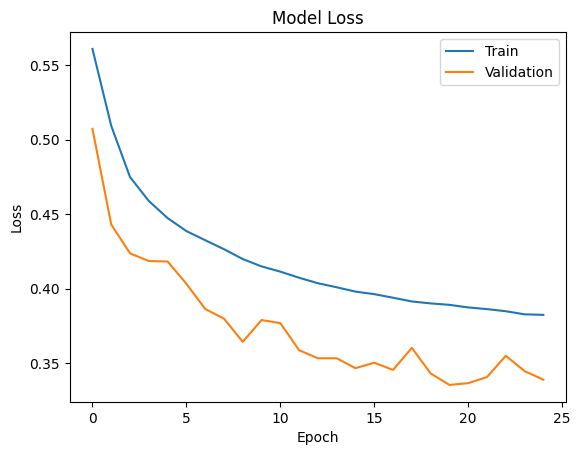

In [18]:
# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [444]:
#bulk
# predictions_both = model.predict(X_test)
# predictions_background = model.predict(X_test1)
# predictions_signal = model.predict(X_test2)

3125/3125 [==============================] - 3s 1ms/step


In [457]:
#daughter
# predictions_both1 = model.predict(X_test)
# predictions_background1 = model.predict(X_test1)
# predictions_signal1 = model.predict(X_test2)

3125/3125 [==============================] - 3s 1ms/step


In [19]:
#daughter + dalitz
predictions_both2 = model.predict(X_test)
predictions_background2 = model.predict(X_test1)
predictions_signal2 = model.predict(X_test2)

3125/3125 [==============================] - 4s 1ms/step


In [85]:
original_df = X_train.copy()
# original_df1 = X_train1.copy()
# original_df2 = X_train2.copy()

In [86]:
original_df

,DMesons_pt,DMesons_eta,DMesons_m,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_fitOutput__ImpactSignificance,inv_mass1,inv_mass2,inv_mass3,inv_mass4,...,daughter_pt1,daughter_pt2,daughter_pt3,daughter_eta1,daughter_eta2,daughter_eta3,daughter_phi1,daughter_phi2,daughter_phi3,particle_type
566853,29.219307,1.119286,2363.254639,0.848439,-0.330522,1.953212,3.448793,0.671242,0.492521,4.669194,...,20.454044,7.784895,0.990825,1.087982,1.203701,1.071299,-1.645808,-1.592034,-1.690381,only_4122
382311,11.679938,-1.317531,2087.216064,0.039914,-0.395586,0.155190,2.503309,0.462700,0.334629,3.713563,...,7.181621,3.375804,1.164419,-1.370006,-1.198351,-1.281614,2.487973,2.293245,2.379799,only_411
241519,24.231191,1.269659,2464.430908,1.087424,0.925585,1.455504,0.501639,0.741827,0.245337,2.787899,...,4.347344,7.039991,12.806197,1.250095,1.280386,1.269871,-3.042267,-3.074275,-3.088649,only_411
719220,13.176404,0.436785,2160.299561,0.120886,-0.221576,1.690471,1.610125,0.771419,1.039851,2.856082,...,7.563798,3.404535,2.255698,0.411726,0.385303,0.583803,-2.538813,-2.365030,-2.380295,only_411
905718,17.424945,-2.214141,2298.672607,0.068214,0.945165,1.206226,0.507188,1.325984,0.617951,3.290768,...,4.590659,10.455518,2.437809,-2.251239,-2.232525,-2.045202,2.757104,2.717668,2.690963,only_411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259178,13.365143,0.162248,2319.205566,2.165743,-0.999705,1.368228,1.950594,1.830855,0.092890,2.943518,...,6.482213,0.874426,6.015223,0.152777,0.173497,0.171463,0.856644,0.835910,0.850968,only_411
365838,16.977629,1.156792,2485.955322,0.171791,0.133141,0.537450,1.788582,1.410299,1.840753,3.095121,...,10.693784,5.687991,0.628915,1.143861,1.111761,1.623564,2.800592,2.927779,2.829226,only_411
131932,18.182744,-0.203413,2285.380371,0.073942,-0.264679,0.216682,1.294023,0.762003,1.750014,2.508966,...,9.244212,3.809190,5.191791,-0.206429,-0.177964,-0.214530,-0.103392,0.003503,0.082985,only_4122
671155,94.625094,0.653040,2332.713135,2.186086,-0.337445,1.539362,1.684196,1.020676,1.765652,2.811200,...,65.525078,20.050047,9.061971,0.649266,0.671018,0.639605,-2.434493,-2.436777,-2.485209,only_4122


In [91]:
drops = ['DMesons_m', 'particle_type']

X = X_train.drop(drops, axis=1)
# X1 = X_train1.drop('DMesons_m', axis=1)
# X2 = X_train2.drop('DMesons_m', axis=1)

In [92]:
y_pred = model.predict(X)

25000/25000 [==============================] - 34s 1ms/step


In [134]:
threshold = 0
events_df = original_df[y_pred >= threshold]
# events_df_signal = original_df[y_pred >= threshold]
# events_df_background = original_df[y_pred <= threshold]
# events_df1 = original_df1[y_pred1 >= threshold]
# events_df2 = original_df2[y_pred2 >= threshold]

In [130]:
events_df_background = events_df[events_df['particle_type'] == 'only_411']
events_df_signal = events_df[events_df['particle_type'] == 'only_4122']

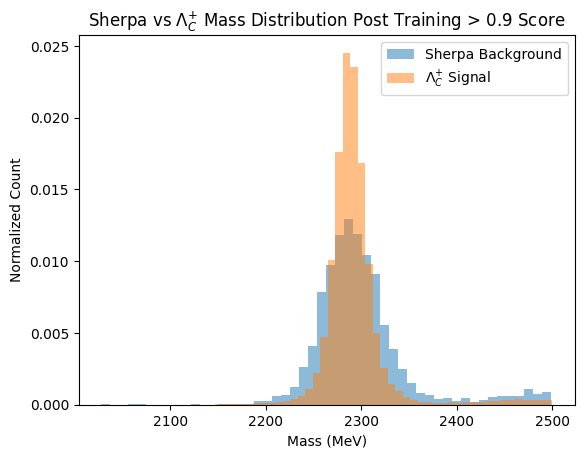

In [132]:
counts, bins, _ = plt.hist(events_df_background["DMesons_m"], bins=50)
counts2, bins2, _ = plt.hist(events_df_signal["DMesons_m"], bins=50)
# Normalize the histogram using the formula
density = counts / (sum(counts) * np.diff(bins))
density2 = counts2 / (sum(counts2) * np.diff(bins2))

# Plot the normalized histogram
plt.clf()
plt.bar(bins[:-1], density, width=np.diff(bins), align='edge', alpha=0.5, label = "Sherpa Background")
plt.bar(bins2[:-1], density2, width=np.diff(bins2), align='edge', alpha=0.5, label = "$\Lambda_C^{+}$ Signal")
plt.title("Sherpa vs $\Lambda_C^{+}$ Mass Distribution Post Training > 0.9 Score")
plt.ylabel("Normalized Count")
plt.xlabel("Mass (MeV)")
plt.legend()
plt.show()

In [117]:
save(passed_both, "passed_both")

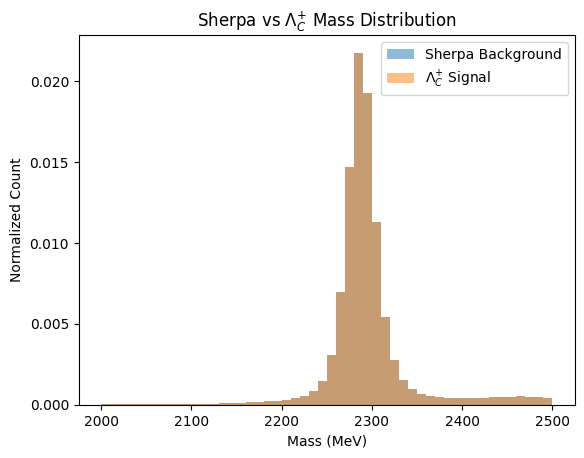

In [ ]:
counts, bins, _ = plt.hist(passed_background["DMesons_m"], bins=50)
counts2, bins2, _ = plt.hist(passed_signal["DMesons_m"], bins=50)
# Normalize the histogram using the formula
density = counts / (sum(counts) * np.diff(bins))
density2 = counts2 / (sum(counts2) * np.diff(bins2))

# Plot the normalized histogram
plt.clf()
plt.bar(bins[:-1], density, width=np.diff(bins), align='edge', alpha=0.5, label = "Sherpa Background")
plt.bar(bins2[:-1], density2, width=np.diff(bins2), align='edge', alpha=0.5, label = "$\Lambda_C^{+}$ Signal")
plt.title("Sherpa vs $\Lambda_C^{+}$ Mass Distribution")
plt.ylabel("Normalized Count")
plt.xlabel("Mass (MeV)")
plt.legend()
plt.show()

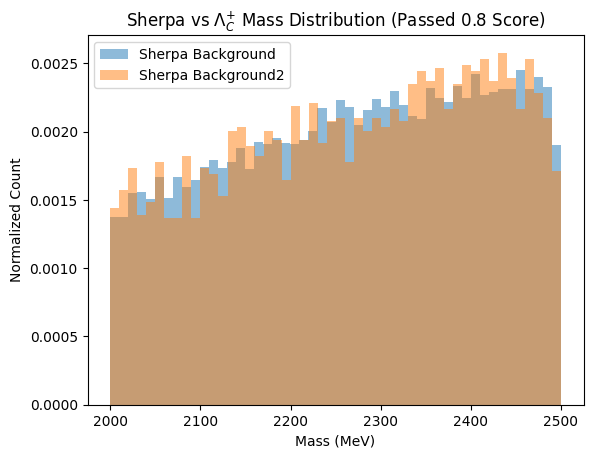

In [40]:
counts, bins, _ = plt.hist(passed_background["DMesons_m"], bins=50)
counts2, bins2, _ = plt.hist(passed_background1["DMesons_m"], bins=50)
# Normalize the histogram using the formula
density = counts / (sum(counts) * np.diff(bins))
density2 = counts2 / (sum(counts2) * np.diff(bins2))

# Plot the normalized histogram
plt.clf()
plt.bar(bins[:-1], density, width=np.diff(bins), align='edge', alpha=0.5, label = "Sherpa Background")
plt.bar(bins2[:-1], density2, width=np.diff(bins2), align='edge', alpha=0.5, label = "Sherpa Background2")
plt.title("Sherpa vs $\Lambda_C^{+}$ Mass Distribution (Passed 0.8 Score)")
plt.ylabel("Normalized Count")
plt.xlabel("Mass (MeV)")
plt.legend()
plt.show()

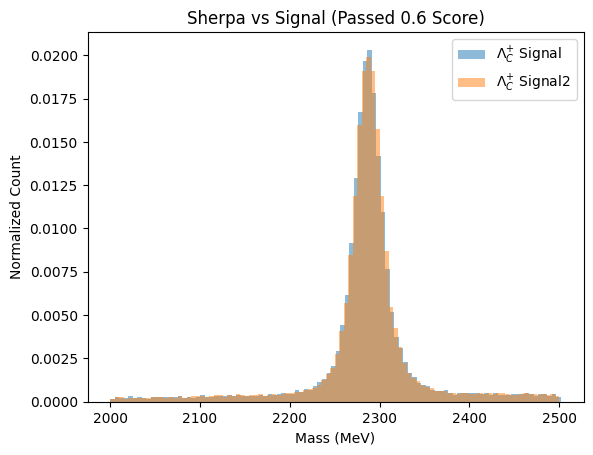

In [42]:
counts, bins, _ = plt.hist(passed_signal["DMesons_m"], bins=100)
counts2, bins2, _ = plt.hist(passed_signal2["DMesons_m"], bins=100)
# Normalize the histogram using the formula
density = counts / (sum(counts) * np.diff(bins))
density2 = counts2 / (sum(counts2) * np.diff(bins2))

# Plot the normalized histogram
plt.clf()
plt.bar(bins[:-1], density, width=np.diff(bins), align='edge', alpha=0.5, label = "$\Lambda_C^{+}$ Signal")
plt.bar(bins2[:-1], density2, width=np.diff(bins2), align='edge', alpha=0.5, label = "$\Lambda_C^{+}$ Signal2")
plt.title("Sherpa vs Signal (Passed 0.6 Score)")
plt.ylabel("Normalized Count")
plt.xlabel("Mass (MeV)")
plt.legend()
plt.show()

In [101]:
#predict accuract given y_test and predictions from model
def pred_accuracy(y_test, predictions):
    D_count, Lambda_count = 0, 0

    predictions_list = []
    for pred in predictions:
        #arbitrary cutoff of 0.5
        if float(pred) > 0.5:
            predictions_list.append(int(1))
            Lambda_count+=1
        elif float(pred) < 0.5:
            predictions_list.append(int(0))
            D_count+=1
            
    accuracy = np.mean(predictions_list == y_test)
    return accuracy

accuracy_both = pred_accuracy(y_test, list(predictions_both2))
accuracy_background = pred_accuracy(y_test1, list(predictions_background2))
accuracy_signal = pred_accuracy(y_test2, list(predictions_signal2))

print("Accuracy for Both: {:.2%}".format(accuracy_both))
print("Accuracy for Only Background: {:.2%}".format(accuracy_background))
print("Accuracy for Only Signal: {:.2%}".format(accuracy_signal))

Accuracy for Both: 85.09%
Accuracy for Only Background: 76.52%
Accuracy for Only Signal: 93.75%


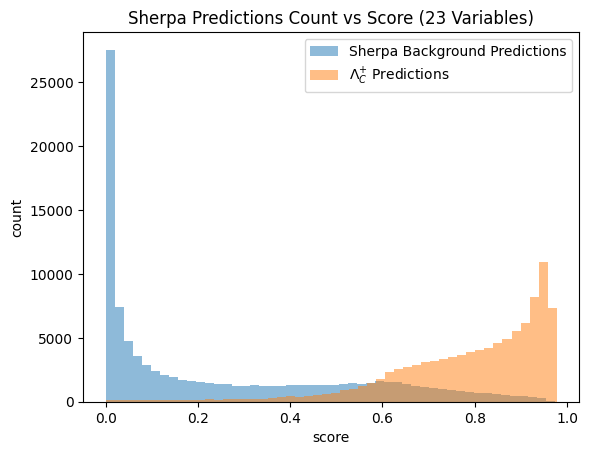

In [102]:
hist = plt.hist(predictions_background2, bins = 50, label = "Sherpa Background Predictions", alpha=0.5)
hist2 = plt.hist(predictions_signal2, bins = 50, label = "$\Lambda_C^{+}$ Predictions", alpha=0.5)
plt.xlabel("score")
plt.ylabel("count")
plt.title("Sherpa Predictions Count vs Score ({} Variables)".format(len(training_columns)))
plt.legend()
plt.show()

In [448]:
#bulk
y_true = list(y_test)
y_pred = predictions_both

In [496]:
#daughter
y_true1 = list(y_test)
y_pred1 = predictions_both1

In [497]:
#daughter + dalitz
y_true2 = list(y_test)
y_pred2 = predictions_both2

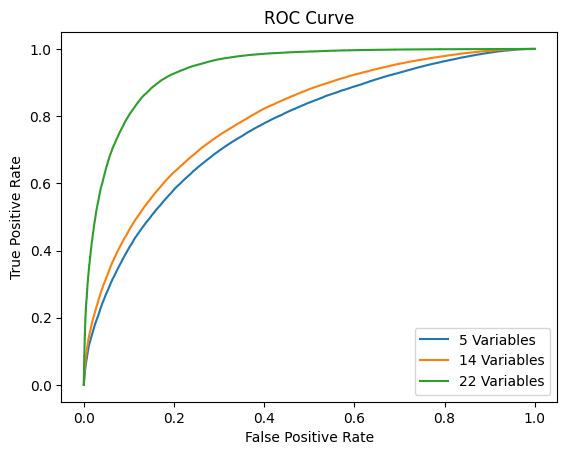

In [499]:
# Calculate TPR and FPR for different threshold values
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
fpr1, tpr1, thresholds1 = roc_curve(y_true1, y_pred1) 
fpr2, tpr2, thresholds2 = roc_curve(y_true2, y_pred2) 

# Plot ROC curve
plt.plot(fpr, tpr, label = "5 Variables")
plt.plot(fpr1, tpr1, label = "14 Variables")
plt.plot(fpr2, tpr2, label = "22 Variables")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC Curve')
plt.show()